### Import Packages

In [4]:
import glob
import numpy as np
import random
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelBinarizer
import keras
from keras.layers import LSTM,Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt

### Set Dataset path 

In [50]:
# set dataset path
SEED = 163
datapath = "C:/Users/BERLIN/Desktop/audio speaker recognition/Jakobovski-free-spoken-digit-dataset-e9e1155/recordings/"

In [51]:
files = glob.glob(datapath + "*.wav")

In [52]:
files[:5]

['C:/Users/BERLIN/Desktop/audio speaker recognition/Jakobovski-free-spoken-digit-dataset-e9e1155/recordings\\0_jackson_0.wav',
 'C:/Users/BERLIN/Desktop/audio speaker recognition/Jakobovski-free-spoken-digit-dataset-e9e1155/recordings\\0_jackson_1.wav',
 'C:/Users/BERLIN/Desktop/audio speaker recognition/Jakobovski-free-spoken-digit-dataset-e9e1155/recordings\\0_jackson_10.wav',
 'C:/Users/BERLIN/Desktop/audio speaker recognition/Jakobovski-free-spoken-digit-dataset-e9e1155/recordings\\0_jackson_11.wav',
 'C:/Users/BERLIN/Desktop/audio speaker recognition/Jakobovski-free-spoken-digit-dataset-e9e1155/recordings\\0_jackson_12.wav']

### Train test split

In [53]:
X_train, X_val = train_test_split(files, test_size=0.2,random_state=SEED)

print("Training sample: {}".format(len(X_train)))
print("Validation sample: {}".format(len(X_val)))

Training sample: 1200
Validation sample: 300


### Data preprocessing

In [54]:
labels = []
for i in range(len(X_train)):
  label = X_train[i].split('/')[-1].split('_')[1]
  if label not in labels:
    labels.append(label)
print(labels)

['theo', 'jackson', 'nicolas']


In [55]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(labels)

def one_hot_encode(x):
  return label_binarizer.transform(x)

In [56]:
y_test = np.array(one_hot_encode(['theo','jackson','nicolas']))

In [57]:
y_test

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [9]:
n_features = 20
max_length = 1000
n_classes = len(labels)

### Train data

In [10]:
random.shuffle(X_train)
X, y = [], []
for wav in X_train:
  wave, sr = librosa.load(wav, mono=True)
  label = wav.split('/')[-1].split("_")[1]
  y.append(label)
  mfcc = librosa.feature.mfcc(wave,sr)
  mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0) 
  X.append(np.array(mfcc))

X_t = np.array(X)
y_t = np.array(one_hot_encode(y))

### Test data

In [11]:
random.shuffle(X_val)
X, y = [], []
for wav in X_val:
  wave, sr = librosa.load(wav, mono=True)
  label = wav.split('/')[-1].split("_")[1]
  y.append(label)
  mfcc = librosa.feature.mfcc(wave,sr)
  mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0) 
  X.append(np.array(mfcc))

X_v = np.array(X)
y_v = np.array(one_hot_encode(y))

In [12]:
X_t.shape

(1200, 20, 1000)

In [13]:
X_v.shape

(300, 20, 1000)

### Model creation

In [14]:
input_shape = (n_features, max_length)
model = keras.models.Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=input_shape,
dropout=0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
callbacks = [ModelCheckpoint('SPEAKER_best_model_.hdf5', save_best_only=True),
            EarlyStopping(monitor='val_accuracy', patience=2)]

### Fitting

In [17]:
history = model.fit(
    X_t, y_t,
    steps_per_epoch=10,
    epochs=10,
    validation_data=(X_v,y_v),
    validation_steps=5,
    validation_freq=1,
    verbose=1,
    callbacks = callbacks
)

Epoch 1/10
10/10 [==============================] - 11s 659ms/step - loss: 0.9792 - accuracy: 0.4975 - val_loss: 0.5187 - val_accuracy: 0.7933
Epoch 2/10
10/10 [==============================] - 4s 395ms/step - loss: 0.4726 - accuracy: 0.7938 - val_loss: 0.3677 - val_accuracy: 0.8867
Epoch 3/10
10/10 [==============================] - 4s 389ms/step - loss: 0.3532 - accuracy: 0.8659 - val_loss: 0.3106 - val_accuracy: 0.9067
Epoch 4/10
10/10 [==============================] - 4s 387ms/step - loss: 0.2538 - accuracy: 0.8968 - val_loss: 0.2666 - val_accuracy: 0.9233
Epoch 5/10
10/10 [==============================] - 4s 367ms/step - loss: 0.1881 - accuracy: 0.9344 - val_loss: 0.2488 - val_accuracy: 0.9167
Epoch 6/10
10/10 [==============================] - 3s 337ms/step - loss: 0.1771 - accuracy: 0.9244 - val_loss: 0.2549 - val_accuracy: 0.9033


In [18]:
def plot_history(history):
    fig, axs = plt.subplots(2)
    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

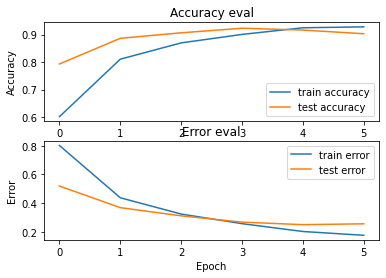

In [19]:
plot_history(history)

In [20]:
X, y = [], []
wav = X_train[501]
wave, sr = librosa.load(wav, mono=True)
label = wav.split('/')[-1].split("_")[1]
y.append(label)
mfcc = librosa.feature.mfcc(wave,sr)
mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0) 
X.append(np.array(mfcc))  

X_test = np.array(X)
y_test = np.array(one_hot_encode(y))

In [21]:
y_pred = model.predict(X_test)
print(y_pred,y_test,label,y)

[[4.2924879e-05 5.9245657e-03 9.9403256e-01]] [[0 0 1]] theo ['theo']


In [22]:
model.save('speaker_model.h5')

# Model deployment

In [63]:
from keras.models import load_model
model = load_model('speaker_model.h5')
X, y = [], []
wav = r"C:\Users\BERLIN\Desktop\audio speaker recognition\Jakobovski-free-spoken-digit-dataset-e9e1155\recordings\1_jackson_3.wav"
wave, sr = librosa.load(wav, mono=True)
label = wav.split('/')[-1].split("_")[0]
y.append(label)
mfcc = librosa.feature.mfcc(wave,sr)
mfcc = np.pad(mfcc, ((0,0), (0, max_length-len(mfcc[0]))), mode='constant', constant_values=0) 
X.append(np.array(mfcc))  

X_test = np.array(X)
y_test = np.array(one_hot_encode(y))

In [64]:
y_pred = model.predict(X_test)
print(y_pred)
if np.argmax(y_pred) == 0:
  print('jackson')
elif np.argmax(y_pred) == 1:
  print('nicolas')
elif np.argmax(y_pred) == 2:
  print('theo')

[[9.9990475e-01 4.5428646e-07 9.4784613e-05]]
jackson
